In [21]:
import pickle
import numpy as np
import pomegranate as pom
import sys
sys.path.append('../src')
from visualization import draw_timeline_with_merged_states, save_png, draw_distribution, draw_infant_each_min_matplotlib
from hmm_model import convert_to_int, convert_to_list_seqs, save_csv, init_hmm

from variables import toys_dict, tasks, toys_list
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils import check_random_state

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

from pathlib import Path
import os 
import importlib
from collections import OrderedDict

### Params 

In [7]:
n_features = 4

### Helpers

### Load data

In [2]:
interval_length = 1.5
with open('../data/interim/20210721_feature_engineering_'+str(interval_length)+'_min.pickle', 'rb') as f:
    feature_dict = pickle.load(f)

with open('../data/interim/20210721_label_'+str(interval_length)+'_min.pickle', 'rb') as f:
    labels_dict = pickle.load(f)

### All tasks

In [8]:
# task_specific_feature = feature_dict['MPS']
no_ops_threshold = 5/60
new_toy_threshold = 2

shift_time_list = np.arange(0, interval_length, .25)

len_list = []

input_list = np.empty((0, n_features))
input_list_ = np.empty((0, n_features))

for task in tasks:
    for subj, shifted_df_dict in feature_dict[task].items():
        for shift_time, feature_vector in shifted_df_dict.items():
            # print(feature_vector)
            input_list = np.vstack((input_list, feature_vector))
            input_list_ = np.concatenate((input_list_, feature_vector))

            len_list.append(len(feature_vector))

In [18]:
all_labels = []
for task in tasks:
    for subj, shifted_sequence in labels_dict[task].items():
        for shift_time, label in shifted_sequence.items(): 
            all_labels.append(label)

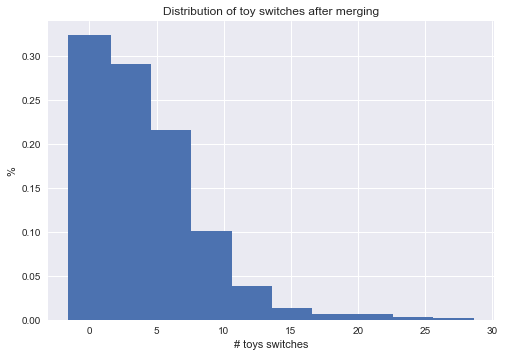

In [57]:
cnt, val = np.histogram(input_list[:,0])
cnt = cnt/cnt.sum()
plt.style.use('seaborn')
plt.bar(val[:-1], cnt, width = 3.2)
plt.xlabel("# toys switches")
plt.ylabel("%")
plt.title("Distribution of toy switches after merging")
plt.show()

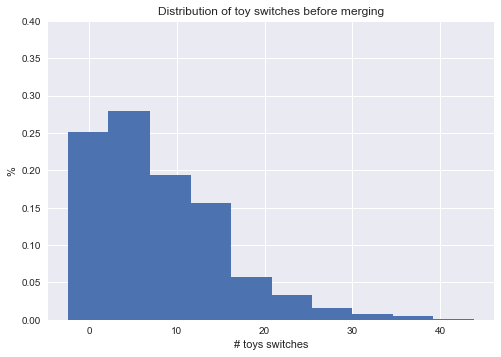

In [32]:
with open('../data/interim/20210718_feature_engineering_1.5_min_original.pickle', 'rb') as f:
    feature_dict = pickle.load(f)

# task_specific_feature = feature_dict['MPS']
interval_length = 1.5  # every 2 minutes
no_ops_threshold = 5/60
new_toy_threshold = 2

shift_time_list = np.arange(0, interval_length, .25)

len_list = []

input_list = np.empty((0, n_features))
input_list_ = np.empty((0, n_features))

for task in tasks:
    for subj, shifted_df_dict in feature_dict[task].items():
        for shift_time, feature_vector in shifted_df_dict.items():
            # print(feature_vector)
            input_list = np.vstack((input_list, feature_vector))
            input_list_ = np.concatenate((input_list_, feature_vector))

            len_list.append(len(feature_vector))
cnt, val = np.histogram(input_list[:,0])
cnt = cnt/cnt.sum()
plt.style.use('seaborn')
plt.bar(val[:-1], cnt, width = 4.8)
plt.xlabel("# toys switches")
plt.ylabel("%")
plt.ylim(top = .4)
plt.title("Distribution of toy switches before merging")
plt.show()

## Discretization

In [10]:
toy_switch_bins = [0, 5, 10, 15]
n_bin_ep_rate = range(len(toy_switch_bins))
discretized_toy_switch_rate = np.digitize(input_list[:,0], toy_switch_bins, right = False)
# discretized_toy_switch_rate = discretized_ep_rate -1
_, counts = np.unique(discretized_toy_switch_rate, return_counts = True) 
heights = counts/counts.sum()
# fig = px.bar(x = n_bin_ep_rate, y = heights, text=counts)
# fig.update_layout(width=800, height=800, 
#                         title_text='Distribution of discretized rate of toy switch',
#                      xaxis = dict(
#                     tickmode = 'array',
#                     # tickvals = ep_rate_dict[window_size],
#                 ))
# fig.show()

In [11]:
discretized_n_toys = np.where(input_list[:,1] > 4, 4, input_list[:,1])
# discretized_toy_switch_rate = discretized_ep_rate -1
n_toy_unique, counts = np.unique(discretized_n_toys, return_counts = True) 
heights = counts/counts.sum()
# fig = px.bar(x = n_toy_unique, y = heights, text=counts)
# fig.update_layout(width=800, height=800, 
#                         title_text='Distribution of discretized rate of number of toy',
#                      xaxis = dict(
#                     tickmode = 'array',
#                 ))
# fig.show()

In [12]:
discretized_n_new_toys = np.where(input_list[:,2] > 4, 4, input_list[:,2])
# discretized_toy_switch_rate = discretized_ep_rate -1
n_new_toys_unique, counts = np.unique(discretized_n_new_toys, return_counts = True) 
heights = counts/counts.sum()
# fig = px.bar(x = n_new_toys_unique, y = heights, text=counts)
# fig.update_layout(width=800, height=800, 
#                         title_text='Distribution of discretized rate of new toys',
#                      xaxis = dict(
#                     tickmode = 'array',
#                     # tickvals = ep_rate_dict[window_size],
#                 ))
# fig.show()

In [13]:
fav_toy_bin = [0, .2, .4, .6, .8]
n_bins_fav_toy = len(fav_toy_bin)

fav_toy_rate_discretized = np.digitize(input_list[:,3].copy(), fav_toy_bin, right = False)
# dominant_toy_rate_discretized = dominant_toy_rate_discretized - 1
_, counts = np.unique(fav_toy_rate_discretized, return_counts = True) 
heights = counts/counts.sum()
# fig = px.bar(x = fav_toy_bin, y = heights, text=counts)
# fig.update_layout(width=800, height=800, 
#                         title_text='Distribution of discretized rate of fav toy ratio',
#                      xaxis = dict(
#                     tickmode = 'array',
#                     tickvals =  fav_toy_bin,
#                 ))
# fig.show()

In [14]:
discretized_input_list = np.hstack((discretized_toy_switch_rate.reshape((-1,1)),\
                                    discretized_n_toys.reshape((-1,1)),\
                                    discretized_n_new_toys.reshape((-1,1)),\
                                    fav_toy_rate_discretized.reshape((-1,1))))
                                    # toy_iou_discretized.reshape((-1,1))))

In [15]:
list_seq = convert_to_list_seqs(discretized_input_list, len_list)
list_seq = convert_to_int(list_seq)

### Fit model

In [16]:
n_states = 5
seed = 1

In [17]:
model = init_hmm(n_states, discretized_input_list.T, seed)
model.bake()
# freeze the no_toys distribution so that its parameters are not updated. 
# "no_toys" state params are set so that all of the lowest bins = 0
for s in model.states:
    if s.name == "no_toys":
        for p in s.distribution.parameters[0]:
            p.frozen = True
# model.fit(list_seq, labels = all_labels)
# model_file_name = 'model_'+str(n_bin_ep_rate)+str(n_bin_toy_rate)+str(n_bin_new_toy_rate)+str(n_bin_dom_toy_ratio)+str(n_bin_toy_iou)+'_'+str(n_components)+'_states.pickle'
# model_file_path = Path('../data/interim/hmm/20200825/discretized/1.5s_new_toy')/model_file_name
# with open(model_file_path, 'wb+') as f:
#     pickle.dump(model, f)

In [19]:
# input: list of observations sequences, each observation sequence is from a session, shape (session_len, )
# labels: list of labels, each label has the same length as the length of the observation sequence.
# If label == 0, the label is fixed, else the model has to learn to infer

model.fit(list_seq, labels = all_labels)
# model_file_path = Path('../models/hmm/20210721/'+str(n_states)+'_states_1.5_min_clean_up.pickle')
# with open(model_file_path, 'wb+') as f:
#     pickle.dump(model, f)

                "frozen" : false
                        },
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
                            "name" : "DiscreteDistribution",
                            "parameters" : [
                                {
                                    "0" : 0.0,
                                    "1" : 0.25728754481697946,
                                    "2" : 0.5697519631086276,
                                    "3" : 0.17296049207439368,
                                    "4" : 2.234964023156591e-109
                                }
                            ],
                            "frozen" : false
                        },
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
                            "name" : "DiscreteDistribution",
                            "parameters" : [
       

In [20]:
# Save the distribution emission

data = []

index_list = [[],[]]


features_obs_dict = {0: len(toy_switch_bins) , 1: 5, 2: 5, 3: 5}

for i in range(n_features):
    single_list = np.empty((features_obs_dict[i], n_states))
    for state_idx, state_i in enumerate(range(n_states)):
        observation_dict = model.states[state_i].distribution.parameters[0][i].parameters[0]
        for idx,k in enumerate(observation_dict.keys()):
            single_list[idx, state_idx] = np.round(observation_dict[k], 2)
    index_list[0].extend([i]*len(observation_dict.keys()))
    index_list[1].extend([i for i in observation_dict.keys()])

    data.extend(single_list)

tuples = list(zip(*index_list))
index = pd.MultiIndex.from_tuples(tuples, names=['feature', 'observation'])
df = pd.DataFrame(data, index = index, columns = ['state '+str(i) for i in range(n_states)])
file_path = Path('/scratch/mom_no_mom/reports/20210721_2/test/')
file_name = 'mean_'+str(n_states)+"_states_seed_"+str(seed)+"_1.5_min.csv"
save_csv(df, file_path, file_name)

# save the transition matrix for all

trans_matrix = pd.DataFrame(np.round(model.dense_transition_matrix()[:n_states+1,:n_states],2))
file_name = 'trans_matrix_'+str(n_states)+"_states_seed_"+str(seed)+'_1.5_min.csv'

save_csv(trans_matrix, file_path, file_name)

#### transition matrix with

In [23]:
i = 0
input_dict = {}
for task in tasks:
    if task not in input_dict.keys():
        input_dict[task] = {}

    for subj, shifted_df_dict in feature_dict[task].items():
        if subj not in input_dict[task].keys():
            input_dict[task][subj] = {}


        for shift_time, feature_vector in shifted_df_dict.items():
            input_dict[task][subj][shift_time] = list_seq[i]
            i += 1

In [24]:
total_log_prob = 0
log_prob_list = []
pred_dict = {}
proba_dict = {}
all_proba_dict = {}

pred_by_task = {}
input_by_task = {}

for task in tasks:
    if task not in pred_dict.keys():
        pred_dict[task] = {}
        proba_dict[task] = {}
        all_proba_dict[task] = {}
        pred_by_task[task] = []
        input_by_task[task] = []

    for subj, shifted_dict in input_dict[task].items():
        if subj not in pred_dict[task].keys():
            pred_dict[task][subj] = {}
            proba_dict[task][subj] = {}
            all_proba_dict[task][subj] = {}

        for shift_time, feature_vector in shifted_dict.items():
            label= model.predict(feature_vector)
            pred_dict[task][subj][shift_time] = label
            pred_by_task[task].extend(label)
            input_by_task[task].extend(feature_vector)

            # if 4 in label:
                # print(feature_vector, label)
            proba_dict[task][subj][shift_time] = np.amax(model.predict_proba(feature_vector), axis = 1)
            log_prob = model.log_probability(feature_vector)
            all_proba_dict[task][subj][shift_time] = model.predict_proba(feature_vector)
            
            log_prob_list.append(log_prob)
print(np.mean(log_prob_list))

-23.36951192735178


In [27]:
with open('../data/interim/20210721_5_states_prediction_all_prob_'+str(interval_length)+'_min.pickle', 'wb+') as f:
    pickle.dump(all_proba_dict, f)

with open('../data/interim/20210721_5_states_prediction_'+str(interval_length)+'_min.pickle', 'wb+') as f:
    pickle.dump(pred_dict, f)

In [23]:
# transmat for each condition
init_prob = {}
for task in tasks:
    first_state = []
    for _ in range(n_states):
        first_state.append(0)
    trans_matrix = np.zeros((n_states, n_states))
    for subj, shifted_dict in pred_dict[task].items():    
        for shift_time, feature in shifted_dict.items():
            # print(feature)
            for idx, state in enumerate(feature[:-1]):
                if idx == 0:
                    first_state[state] += 1
                # if state != feature[idx + 1]:
                trans_matrix[state][feature[idx + 1]] += 1
    first_state = np.array(first_state)/np.array(first_state) .sum()
    init_prob[task] = first_state
    row_sum = trans_matrix.sum(axis=1)
    normalized_trans_matrix = trans_matrix/row_sum[:, np.newaxis]
    # print(np.round(normalized_trans_matrix,3))
    # print(np.sum(normalized_trans_matrix, axis = 1))

    # features = ['front leg', 'back leg', 'front hand', 'back hand']
    df = pd.DataFrame(data = np.vstack((np.round(normalized_trans_matrix,3), first_state)), index = ["State " + str(i) for i in range(n_states)] + ['Init prob'], columns = ["State " + str(i) for i in range(n_states)])
    # file_path = Path('~/Documents/mcs_handrail/reports/continuous_hmm/hmmlearn')
    # file_path = Path('/scratch/mom_no_mom/reports/20210721/')

    file_name = 'transmat_'+str(task)+'_frames_'+str(n_states)+'_1.5_min.csv'
    save_csv(df, file_path, file_name)

/scratch/lehoang_python36/lib64/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



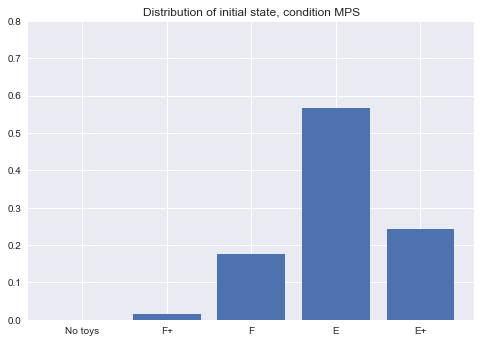

In [75]:
plt.style.use('seaborn')

task = "MPS"
plt.bar(np.arange(5), init_prob[task][[4,3,0,2,1]])
plt.ylim(top = 0.8)
plt.xticks(np.arange(5), ["No toys", "F+", "F", "E", "E+"])
plt.title("Distribution of initial state, condition " + str(task))
plt.show()


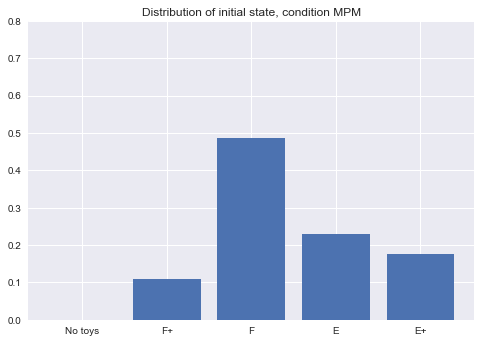

In [76]:
task = "MPM"
plt.bar(np.arange(5), init_prob[task][[4,3,0,2,1]])
plt.ylim(top = 0.8)
plt.xticks(np.arange(5), ["No toys", "F+", "F", "E", "E+"])
plt.title("Distribution of initial state, condition " + str(task))
plt.show()


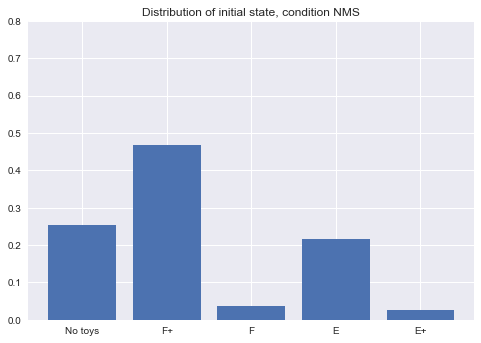

In [77]:
task = "NMS"
plt.bar(np.arange(5), init_prob[task][[0,2,3,1,4]])
plt.ylim(top = 0.8)
plt.xticks(np.arange(5), ["No toys", "F+", "F", "E", "E+"])
plt.title("Distribution of initial state, condition " + str(task))
plt.show()


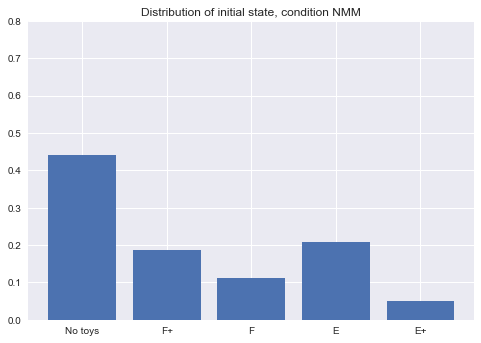

In [78]:
task = "NMM"
plt.bar(np.arange(5), init_prob[task][[0,2,3,1,4]])
plt.ylim(top = 0.8)
plt.xticks(np.arange(5), ["No toys", "F+", "F", "E", "E+"])
plt.title("Distribution of initial state, condition " + str(task))
plt.show()


In [29]:
state_name_dict = OrderedDict({4: "No_toys", 2: "F+", 0: "F", 3: "E", 1:"E+"})

## Compare the distribution for task specific 

In [4]:
n_states = 5

In [7]:
state_name_dict = OrderedDict({4: "No_toys", 2: "F+", 0: "F", 3: "E", 1:"E+"})
feature_names = ["# toys switches", "# toys", "# new toys", 'fav toy ratio']

In [8]:
with open('../data/interim/20210721_5_states_prediction_1.5_min.pickle', 'rb') as f:
    pred_dict = pickle.load(f)

with open('../data/interim/20210721_5_states_prediction_all_prob_1.5_min.pickle', 'rb') as f:
    all_proba_dict = pickle.load(f)

In [9]:
flatten_pred_dict = {}
flatten_pred = []
flatten_proba_dict = {}
for task in tasks:
    flatten_pred_dict[task] = []
    flatten_proba_dict[task] = []
    task_specific_pred_dict = pred_dict[task]
    for subj, subj_dict in task_specific_pred_dict.items():
        for shift_time, pred in subj_dict.items():
            flatten_pred_dict[task].extend(pred)
            flatten_proba_dict[task].extend(all_proba_dict[task][subj][shift_time])
            flatten_pred.extend(pred)

In [11]:
task_len = [len(flatten_pred_dict[task]) for task in tasks]
plt.style.use('seaborn')
x_ticks_dict = {0: ["[0, 5)", '[5, 10)', '[10, 15)', '[15+'], 1: ['0', '1', '2', '3', '4+'], 2: ['0', '1', '2', '3', '4+'], 3: ["[0, .2)", '[.2, .4)', '[.4, .6)', '[.6, .8)', '[.8, 1]']}
feature_values = {0: range(1,5), 1: range(5), 2: range(5), 3: range(1,6)}

In [26]:
task_specific_input = convert_to_list_seqs(discretized_input_list, task_len)
task_specific_input_dict = {}
for i, task in enumerate(tasks):
    task_specific_input_dict[task] = task_specific_input[i]

In [116]:
print(len(discretized_input_list[np.array(flatten_pred) == 0]))

386


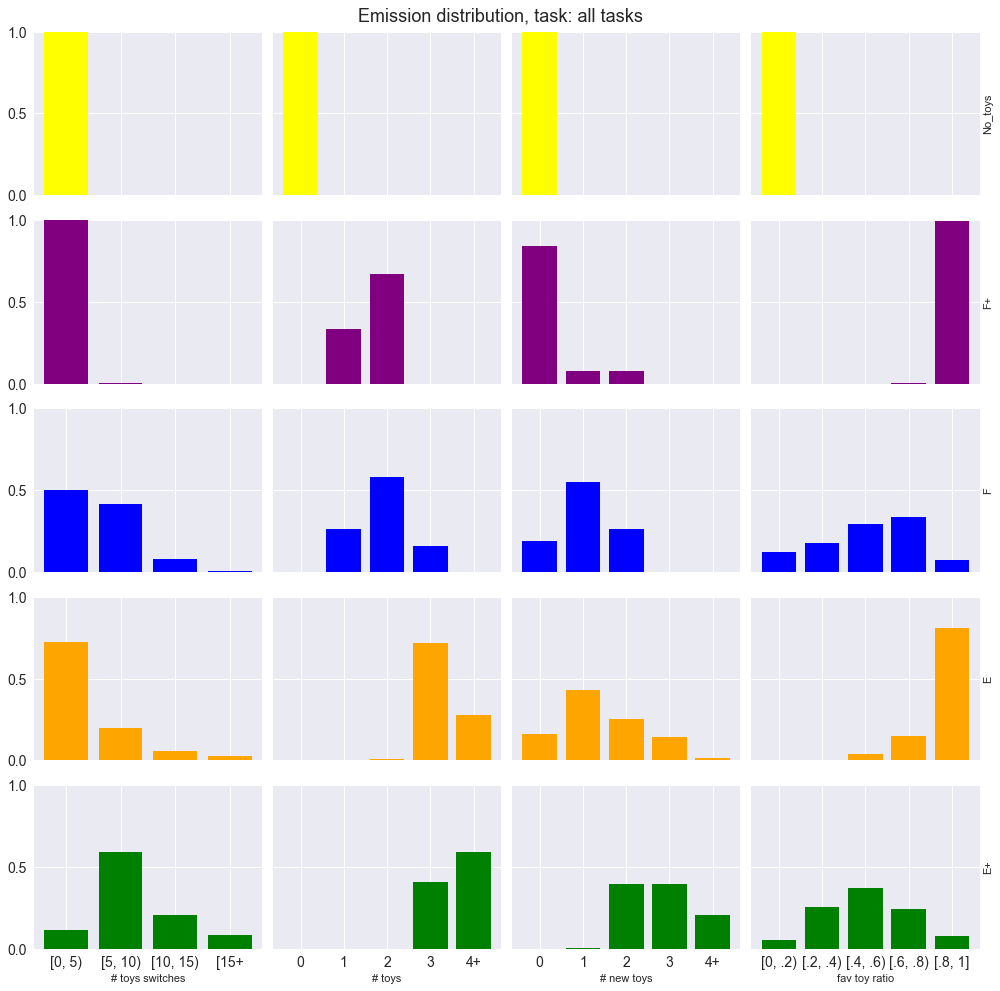

In [28]:
plt.style.use('seaborn')
draw_distribution(n_features, state_name_dict, discretized_input_list, np.array(flatten_pred), "all tasks",feature_names, x_ticks_dict, feature_values)

[0 1 2 3 4] [1715 1539  837  600  185] [0.35172272 0.31562756 0.1716571  0.12305168 0.03794094]
{0: 0.35172272354388845, 1: 0.31562756357670224, 2: 0.17165709598031173, 3: 0.12305168170631665, 4: 0.03794093519278097}


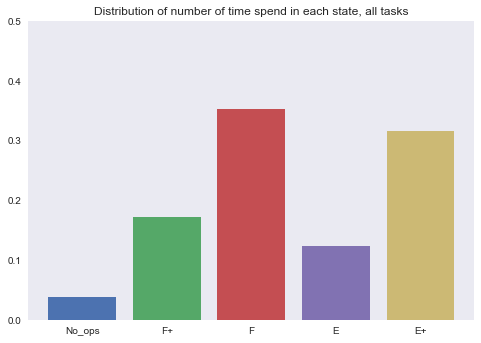

In [31]:
n_states = 5
val, cnt = np.unique(np.array(flatten_pred).astype(int), return_counts = True)
pct = cnt/cnt.sum()

print(val, cnt, pct)

task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
print(task_state_pct)

for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"])
plt.ylim(top = .5)
plt.grid(b=None)
plt.title("Distribution of number of time spend in each state, all tasks")
plt.show()

[0 1 2 3 4] [615 258 296  65   3] [0.49717057 0.20856912 0.2392886  0.05254648 0.00242522]


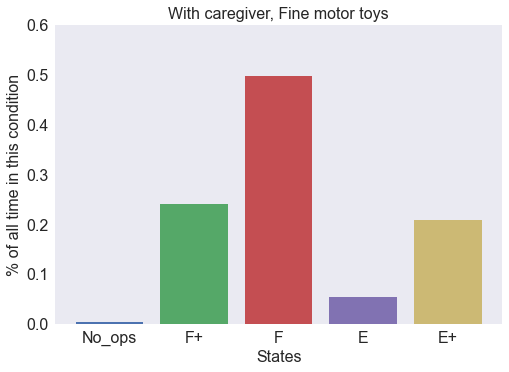

In [38]:
task = "MPS"
val, cnt = np.unique(np.array(flatten_pred_dict[task]).astype(int), return_counts = True)
pct = cnt/cnt.sum()
print(val, cnt, pct)

task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.ylim(top = .6)
plt.grid(b=None)
plt.xlabel('States', fontsize = 16)
plt.ylabel('% of all time in this condition', fontsize = 16)
plt.yticks(fontsize = 16)


plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"], fontsize = 16)
plt.title("With caregiver, Fine motor toys", fontsize = 16)
plt.show()

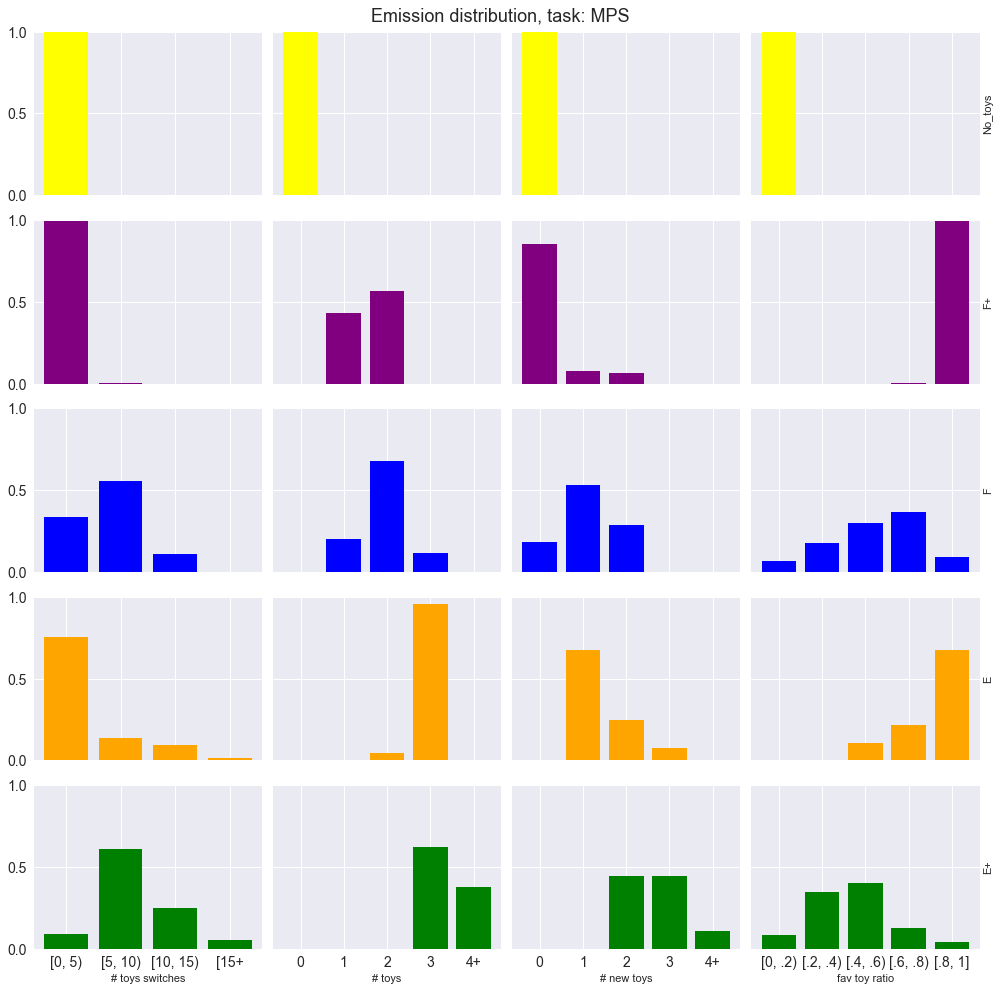

In [48]:
task = "MPS"
draw_distribution(n_features, state_name_dict, task_specific_input_dict[task], np.array(flatten_pred_dict[task]), task,feature_names, x_ticks_dict, feature_values)


[0 1 2 3] [265 563 189 217]
{0: 0.21474878444084278, 1: 0.45623987034035657, 2: 0.15316045380875204, 3: 0.17585089141004862, 4: 0}


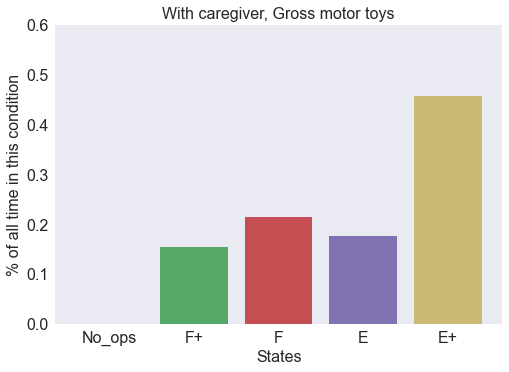

In [36]:
task = "MPM"
val, cnt = np.unique(np.array(flatten_pred_dict[task]).astype(int), return_counts = True)
pct = cnt/cnt.sum()
print(val, cnt)
task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
print(task_state_pct)
# task_state_pct[4] = 0
for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"])
plt.ylim(top = .6)
plt.grid(b=None)
plt.xlabel('States', fontsize = 16)
plt.ylabel('% of all time in this condition', fontsize = 16)
plt.yticks(fontsize = 16)


plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"], fontsize = 16)
plt.title("With caregiver, Gross motor toys", fontsize = 16)
plt.show()

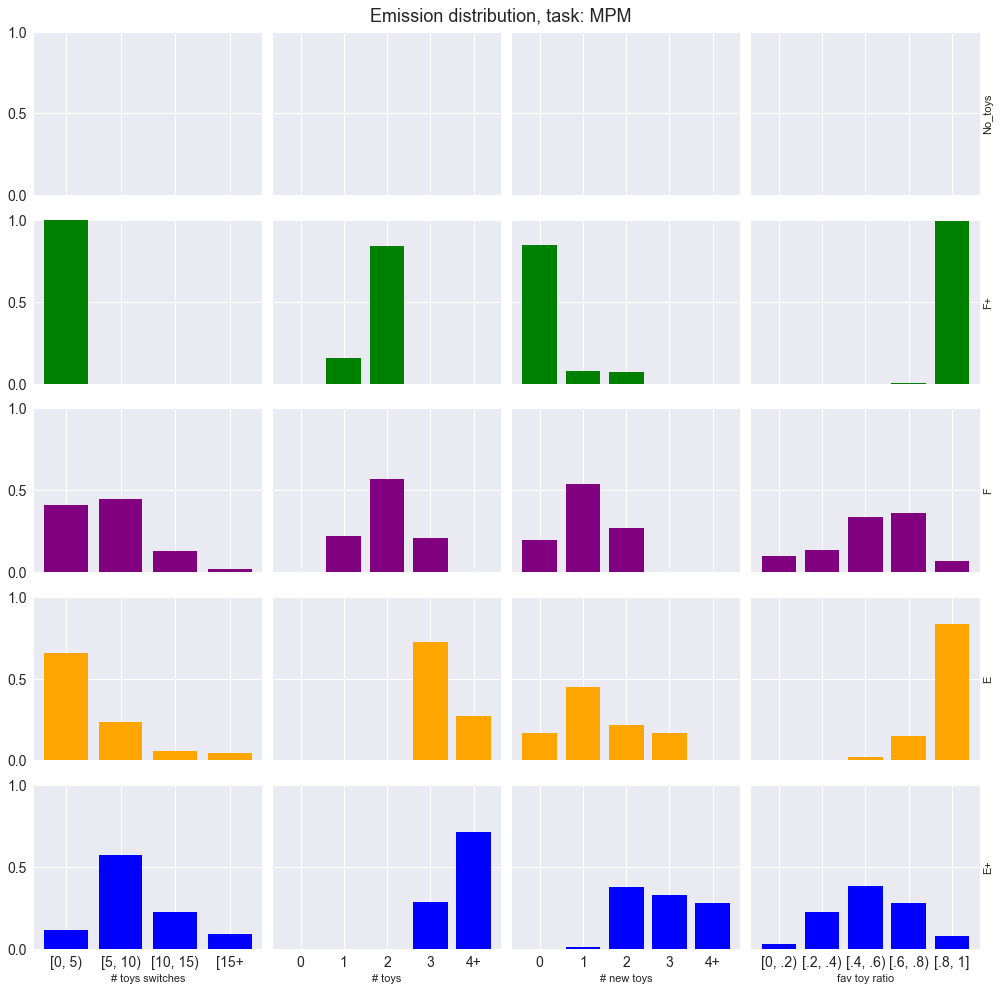

In [93]:
task = 'MPM'
draw_distribution(n_features, state_name_dict, np.array(input_by_task[task]), np.array(pred_by_task[task]), task,feature_names, x_ticks_dict, feature_values)

[0 1 2 3 4] [570 286 206  59  96]
{0: 0.4683648315529992, 1: 0.23500410846343467, 2: 0.16926869350862778, 3: 0.04847986852917009, 4: 0.07888249794576828}


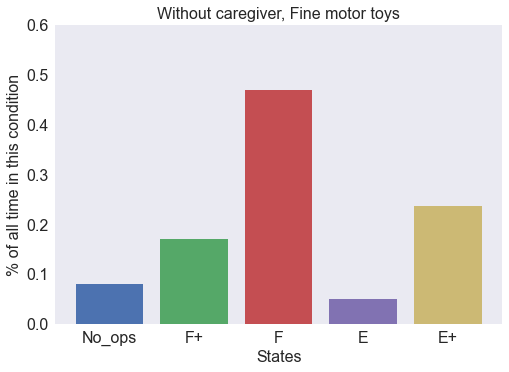

In [39]:
task = "NMS"
val, cnt = np.unique(np.array(flatten_pred_dict[task]).astype(int), return_counts = True)
pct = cnt/cnt.sum()
print(val, cnt)
task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
print(task_state_pct)
for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"])
plt.ylim(top = .6)
plt.grid(b=None)
plt.xlabel('States', fontsize = 16)
plt.ylabel('% of all time in this condition', fontsize = 16)
plt.yticks(fontsize = 16)


plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"], fontsize = 16)
plt.title("Without caregiver, Fine motor toys", fontsize = 16)
plt.show()

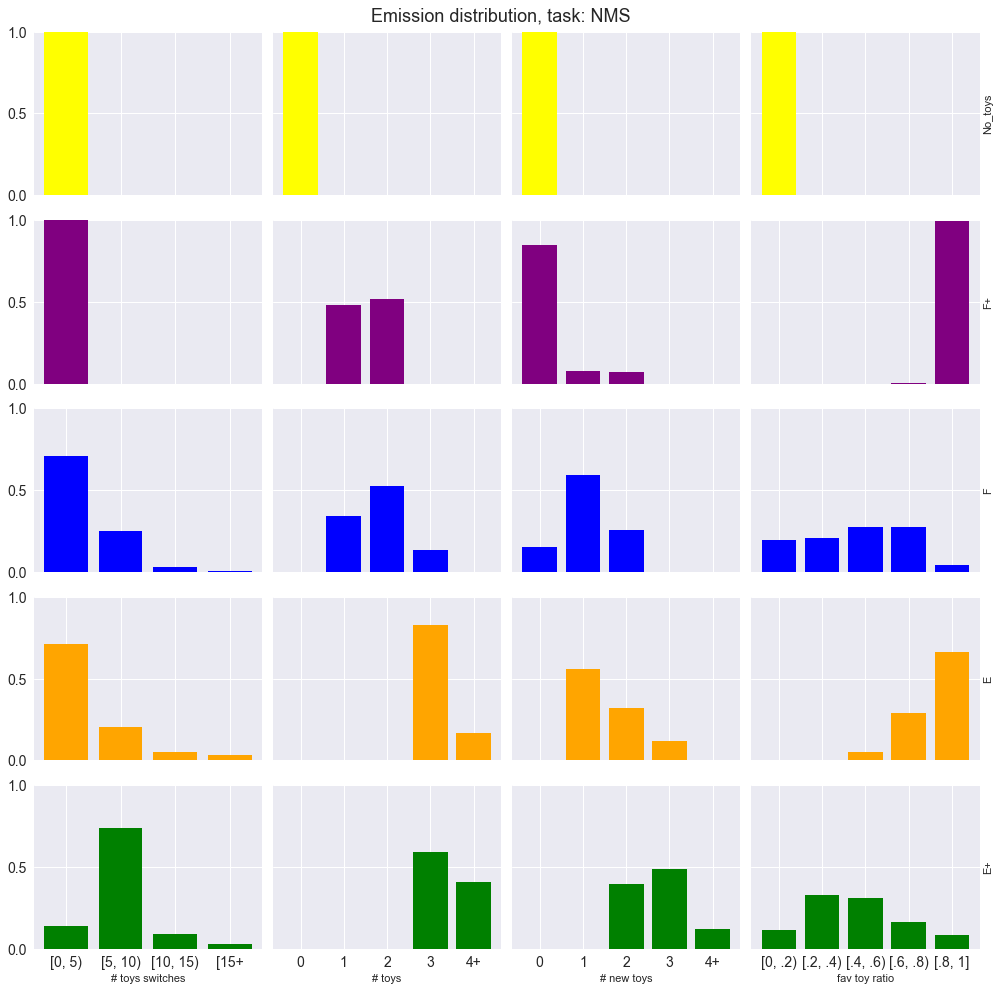

In [51]:
task = 'NMS'
draw_distribution(n_features, state_name_dict, task_specific_input_dict[task], np.array(flatten_pred_dict[task]), task,feature_names, x_ticks_dict, feature_values)

[0 1 2 3 4] [265 432 146 259  86]


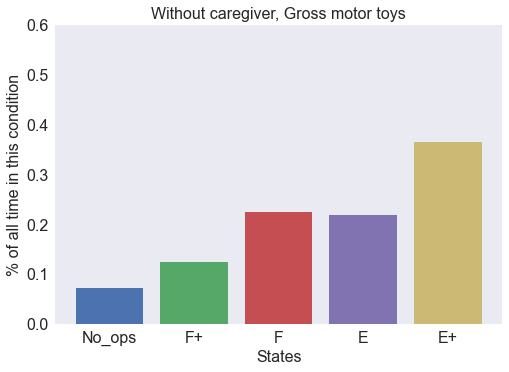

In [40]:
task = "NMM"

val, cnt = np.unique(np.array(flatten_pred_dict[task]).astype(int), return_counts = True)
pct = cnt/cnt.sum()

print(val, cnt)
task_state_pct = {v: pct[idx] for idx, v in enumerate(val)}
for i in range(n_states):
    if i not in task_state_pct.keys():
        task_state_pct[i] = 0
for idx, state in enumerate(list(state_name_dict.keys())):
    plt.bar(idx, task_state_pct[state])
# plt.hist(np.array(flatten_pred_dict[task]).astype(int))
plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"])
plt.ylim(top = .6)
plt.grid(b=None)
plt.xlabel('States', fontsize = 16)
plt.ylabel('% of all time in this condition', fontsize = 16)
plt.yticks(fontsize = 16)


plt.xticks([0,1,2,3,4], ["No_ops", "F+", "F", "E", "E+"], fontsize = 16)
plt.title("Without caregiver, Gross motor toys", fontsize = 16)
plt.show()

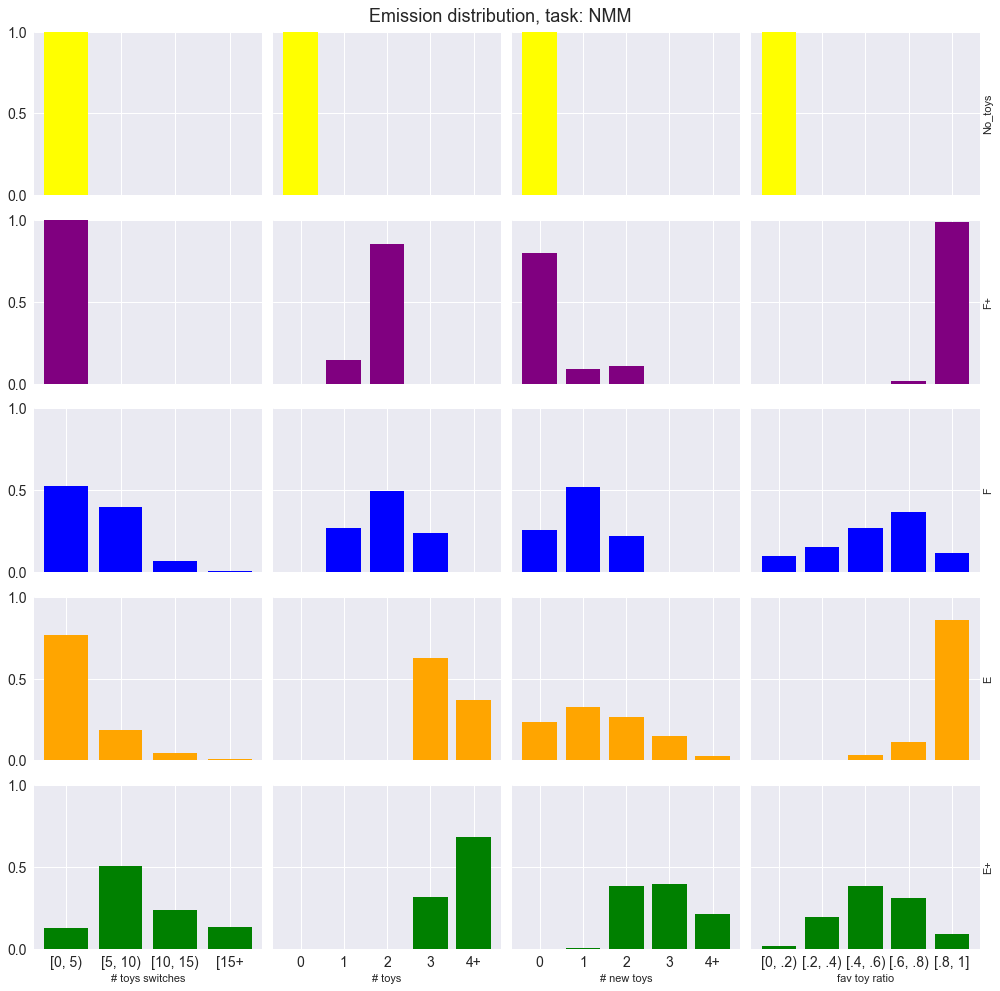

In [53]:
task = 'NMM'
draw_distribution(n_features, state_name_dict, task_specific_input_dict[task], np.array(flatten_pred_dict[task]), task,feature_names,  x_ticks_dict, feature_values)

### Correlation between features

In [60]:
all_feature_df = pd.DataFrame(data = {'n_of_toy_switches':input_list[:,0], 'n_toys': input_list[:,1], "n_new_toys": input_list[:,2], 'fav_toy_duration': input_list[:,3], "prediction": flatten_pred})
all_feature_df['prediction'] = all_feature_df['prediction'].replace(state_name_dict)

fig = px.scatter_3d(all_feature_df, x='n_of_toy_switches', y='n_new_toys', z='fav_toy_duration',
              color='prediction')
fig.show()

In [61]:
fig = px.scatter_3d(all_feature_df, x='n_of_toy_switches', y='n_toys', z='fav_toy_duration',
              color='prediction')
fig.show()

In [77]:
print(np.corrcoef(np.hstack((all_feature_df['n_of_toy_switches'].to_numpy().reshape((-1,1)),\
            all_feature_df['n_toys'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_of_toy_switches', y = 'n_toys',\
            color = 'prediction')
fig.show()

[[1.         0.47004583]
 [0.47004583 1.        ]]


In [78]:
print(np.corrcoef(np.hstack((all_feature_df['n_of_toy_switches'].to_numpy().reshape((-1,1)),\
            all_feature_df['n_new_toys'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_of_toy_switches', y = 'n_new_toys',\
            color = 'prediction')
fig.show()

[[1.         0.38280023]
 [0.38280023 1.        ]]


In [79]:
print(np.corrcoef(np.hstack((all_feature_df['n_of_toy_switches'].to_numpy().reshape((-1,1)),\
            all_feature_df['fav_toy_duration'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_of_toy_switches', y = 'fav_toy_duration',\
            color = 'prediction')
fig.show()

[[1.         0.18745557]
 [0.18745557 1.        ]]


In [80]:
print(np.corrcoef(np.hstack((all_feature_df['n_toys'].to_numpy().reshape((-1,1)),\
            all_feature_df['n_new_toys'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_toys', y = 'n_new_toys',\
            color = 'prediction')
fig.show()

[[1.         0.87531867]
 [0.87531867 1.        ]]


In [81]:
print(np.corrcoef(np.hstack((all_feature_df['n_toys'].to_numpy().reshape((-1,1)),\
            all_feature_df['fav_toy_duration'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_toys', y = 'fav_toy_duration',\
            color = 'prediction')
fig.show()

[[1.         0.08885846]
 [0.08885846 1.        ]]


In [82]:
print(np.corrcoef(np.hstack((all_feature_df['n_new_toys'].to_numpy().reshape((-1,1)),\
            all_feature_df['fav_toy_duration'].to_numpy().reshape((-1,1)))), rowvar = False))

fig = px.scatter(all_feature_df, x = 'n_new_toys', y = 'fav_toy_duration',\
            color = 'prediction')
fig.show()

[[ 1.         -0.08316515]
 [-0.08316515  1.        ]]


### Timeline of infants at each states

In [44]:
with open('../data/interim/20210721_5_states_merged_prediction_1.5_min.pickle', 'rb') as f:
    merged_pred_dict_all = pickle.load(f)

In [46]:
def get_longest_item(dictionary):
    return max((len(v)) for _,v in dictionary.items())

In [76]:
print(get_longest_item(merged_pred_dict_all[task]))

22


In [47]:
cnt_dict_task_specific = {}
for task in tasks:
    cnt_dict_task_specific[task] = {}
    len_ = get_longest_item(merged_pred_dict_all[task])
    for i in range(n_states):
        cnt_dict_task_specific[task][i] = [0]*len_

In [48]:
for task in tasks:
    for subj, state_list in merged_pred_dict_all[task].items():
        for idx, state in enumerate(state_list):

            cnt_dict_task_specific[task][state][idx] += 1
    

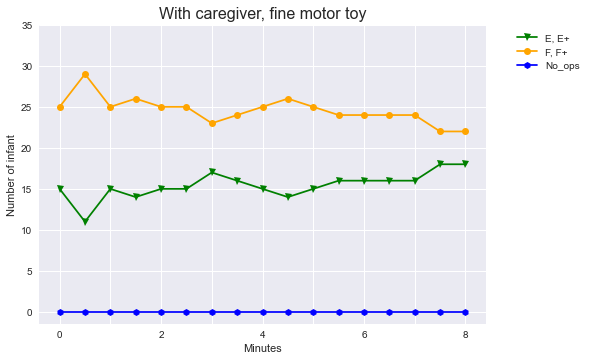

In [57]:
task =  "MPS"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][0]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][2]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][4], "With caregiver, fine motor toy")


In [41]:
task =  "MPS"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][0]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][2]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][4])



NameError: name 'cnt_dict_task_specific' is not defined

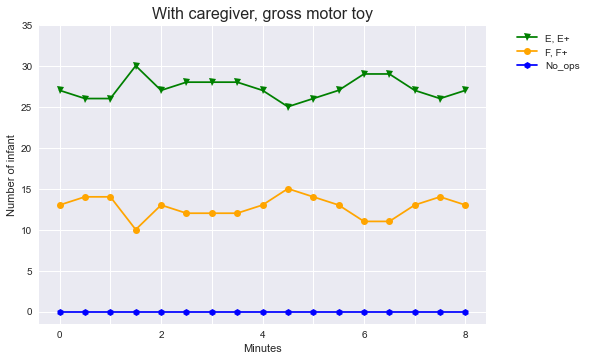

In [58]:
task =  "MPM"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][0]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][2]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][4], "With caregiver, gross motor toy")


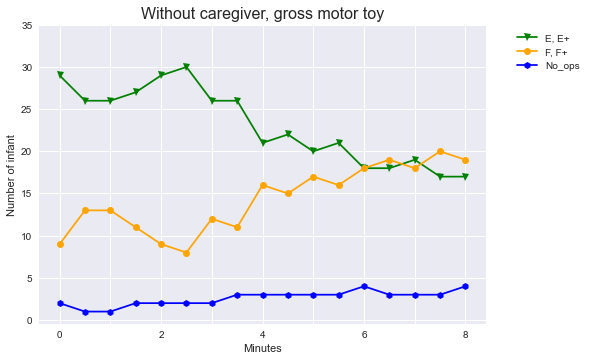

In [59]:
task =  "NMM"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][0]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][2]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][4], "Without caregiver, gross motor toy")


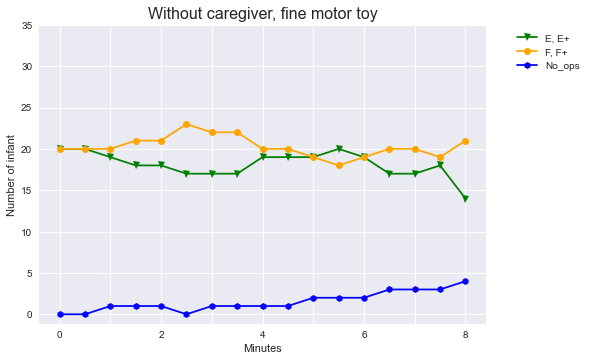

In [60]:
task =  "NMS"
focus_state = np.array(cnt_dict_task_specific[task][3]) + np.array(cnt_dict_task_specific[task][0]) 
explore_state = np.array(cnt_dict_task_specific[task][1]) + np.array(cnt_dict_task_specific[task][2]) 
draw_infant_each_min_matplotlib(focus_state, explore_state, cnt_dict_task_specific[task][4], "Without caregiver, fine motor toy")
